In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import spline
%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

import matplotlib
matplotlib.style.use('ggplot')
pd.options.display.max_rows = 100

import warnings
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
warnings.filterwarnings('ignore')

### Load Data


In [2]:
########################################################
# Define variables which we will use later in the script
########################################################

parse_date_cols = ['dt_prediction_date', 'dt_target_date', 'dt_flight_date']
target_cols = ['num_pax_000_014_mins_before_sdt', 'num_pax_015_029_mins_before_sdt', 'num_pax_030_044_mins_before_sdt', 'num_pax_045_059_mins_before_sdt', 'num_pax_060_074_mins_before_sdt', 'num_pax_075_089_mins_before_sdt', 'num_pax_090_104_mins_before_sdt', 'num_pax_105_119_mins_before_sdt',  'num_pax_120_134_mins_before_sdt', 'num_pax_135_149_mins_before_sdt', 'num_pax_150_164_mins_before_sdt', 'num_pax_165_179_mins_before_sdt',  'num_pax_180_194_mins_before_sdt', 'num_pax_195_209_mins_before_sdt', 'num_pax_210_224_mins_before_sdt', 'num_pax_225_239_mins_before_sdt', 'num_pax_240plus_mins_before_sdt']


In [3]:
###############################################
# Read in csv file and parse dates. Also generate dataframe with the target cases ordered by id
###############################################
df = pd.read_csv("./train.csv", parse_dates = parse_date_cols)
df_target_cases = df[df['cat_case_type'] == 'Target'].set_index('id').sort_index()[target_cols]
df_train=df[df['cat_case_type']=='Expl'].set_index('id')
df_target=df[df['cat_case_type']=='Target'].set_index('id')
df = df.set_index('id')

In [4]:
df_train.head(5)

,dt_prediction_date,dt_target_date,s_model_type,cat_case_type,cat_i_flightno,dt_flight_date,num_flight_year,num_flight_month,num_flight_weekofyear,num_flight_dayofweek,...,num_pax_105_119_mins_before_sdt,num_pax_120_134_mins_before_sdt,num_pax_135_149_mins_before_sdt,num_pax_150_164_mins_before_sdt,num_pax_165_179_mins_before_sdt,num_pax_180_194_mins_before_sdt,num_pax_195_209_mins_before_sdt,num_pax_210_224_mins_before_sdt,num_pax_225_239_mins_before_sdt,num_pax_240plus_mins_before_sdt
id,,,,,,,,,,,,,,,,,,,,,
2,2013-01-02,2014-01-02,52_weeks,Expl,10536,2013-01-02,2013,1,1,2,...,10,8,2,0,0,0,0,0,0,0
2,2013-01-02,2014-01-02,52_weeks,Expl,10536,2012-12-31,2012,12,1,0,...,16,16,6,7,6,1,0,0,1,0
2,2013-01-02,2014-01-02,52_weeks,Expl,10536,2012-12-30,2012,12,52,6,...,28,9,9,4,0,0,0,0,0,0
2,2013-01-02,2014-01-02,52_weeks,Expl,10536,2012-12-29,2012,12,52,5,...,15,10,9,9,1,0,0,3,0,1
2,2013-01-02,2014-01-02,52_weeks,Expl,10536,2012-12-28,2012,12,52,4,...,2,22,12,2,2,0,2,0,0,0


In [5]:
df_target.head(5)

,dt_prediction_date,dt_target_date,s_model_type,cat_case_type,cat_i_flightno,dt_flight_date,num_flight_year,num_flight_month,num_flight_weekofyear,num_flight_dayofweek,...,num_pax_105_119_mins_before_sdt,num_pax_120_134_mins_before_sdt,num_pax_135_149_mins_before_sdt,num_pax_150_164_mins_before_sdt,num_pax_165_179_mins_before_sdt,num_pax_180_194_mins_before_sdt,num_pax_195_209_mins_before_sdt,num_pax_210_224_mins_before_sdt,num_pax_225_239_mins_before_sdt,num_pax_240plus_mins_before_sdt
id,,,,,,,,,,,,,,,,,,,,,
1,2013-01-01,2014-01-01,52_weeks,Target,11075,2014-01-01,2014,1,1,2,...,12,12,0,0,0,0,0,0,0,0
2,2013-01-02,2014-01-02,52_weeks,Target,10536,2014-01-02,2014,1,1,3,...,18,16,10,4,3,0,0,0,0,0
3,2013-01-04,2014-01-04,52_weeks,Target,10104,2014-01-04,2014,1,1,5,...,13,22,11,5,0,0,0,0,0,2
4,2013-01-04,2014-01-04,52_weeks,Target,11015,2014-01-04,2014,1,1,5,...,28,26,22,6,2,7,0,0,0,1
5,2013-01-04,2014-01-04,52_weeks,Target,10015,2014-01-04,2014,1,1,5,...,1,5,0,0,0,0,0,0,0,0


In [11]:
def calculate_distance(x1,x2):
    timelist=["num_flight_month","num_flight_weekofyear",\
              "num_flight_dayofweek","cat_sdt_hour"]
    cat_list=["cat_i_airport","cat_i_city","cat_destination_group_id",\
          "cat_longhaul_ind","cat_s_plane_capacity","cat_flight_class_type_id"]
    ord_list=["ord_leisure","ord_irish_residents","ord_trip_duration",\
          "ord_female","ord_party_size","ord_bag_checkin","ord_arrive_by_car"]
    period=np.array([12,52,7,24])
    
    dxn=abs(x1[timelist]-x2[timelist])
    dxn=np.where(dxn > 0.5 * period, (dxn - period)/period, dxn/period)
    dxc=np.where(x1[cat_list]==x2[cat_list],0,1)
    dxo=abs(x1[ord_list]-x2[ord_list])/5.0
    
    
    dx_total=(sum(dxn**2)+sum(dxc**2)+sum(dxo**2))**0.5
    
    return dx_total

    

In [110]:
for test_index, test_row in df_target.iterrows():
    if(test_index>1): break
    nearest_neighbours=[]
#    print (index,row['cat_i_flightno'],row['dt_prediction_date'],row['dt_target_date'],row['s_model_type'])
#    test_df=df_train[(df_train['cat_i_flightno']==row['cat_i_flightno']) & (df_train['s_model_type']==row['s_model_type']) & (df_train['cat_case_type']=='Expl')]
#    if test_df.empty: 
#        count+=1
    for train_index, train_row in df_train[df_train['s_model_type']==test_row['s_model_type']].iterrows():
#        if(train_index>10): break
        dist=calculate_distance(test_row,train_row)
#        print([test_index,train_index,dist])
     
        nearest_neighbours.append([test_index,train_index,dist])

nearest_neighbours=np.asarray(nearest_neighbours)

[[  1.00000000e+00   3.90000000e+01   1.41875354e+00]
 [  1.00000000e+00   3.90000000e+01   1.42592769e+00]
 [  1.00000000e+00   3.90000000e+01   1.42592769e+00]
 [  1.00000000e+00   1.55400000e+03   1.43819928e+00]
 [  1.00000000e+00   1.55400000e+03   1.44322838e+00]
 [  1.00000000e+00   1.55400000e+03   1.44335650e+00]
 [  1.00000000e+00   1.55400000e+03   1.44374078e+00]
 [  1.00000000e+00   1.22000000e+02   1.44398269e+00]
 [  1.00000000e+00   1.55400000e+03   1.44527690e+00]
 [  1.00000000e+00   1.55400000e+03   1.44527690e+00]
 [  1.00000000e+00   2.61000000e+02   1.44614380e+00]
 [  1.00000000e+00   3.16200000e+03   1.44723677e+00]
 [  1.00000000e+00   3.90000000e+01   1.44723677e+00]
 [  1.00000000e+00   1.55400000e+03   1.44767737e+00]
 [  1.00000000e+00   3.90000000e+01   1.44963399e+00]]


In [111]:
print(nearest_neighbours[nearest_neighbours[:,2].argsort()][:50])

[[  1.00000000e+00   3.90000000e+01   1.41875354e+00]
 [  1.00000000e+00   3.90000000e+01   1.42592769e+00]
 [  1.00000000e+00   3.90000000e+01   1.42592769e+00]
 [  1.00000000e+00   1.55400000e+03   1.43819928e+00]
 [  1.00000000e+00   1.55400000e+03   1.44322838e+00]
 [  1.00000000e+00   1.55400000e+03   1.44335650e+00]
 [  1.00000000e+00   1.55400000e+03   1.44374078e+00]
 [  1.00000000e+00   1.22000000e+02   1.44398269e+00]
 [  1.00000000e+00   1.55400000e+03   1.44527690e+00]
 [  1.00000000e+00   1.55400000e+03   1.44527690e+00]
 [  1.00000000e+00   2.61000000e+02   1.44614380e+00]
 [  1.00000000e+00   3.16200000e+03   1.44723677e+00]
 [  1.00000000e+00   3.90000000e+01   1.44723677e+00]
 [  1.00000000e+00   1.55400000e+03   1.44767737e+00]
 [  1.00000000e+00   3.90000000e+01   1.44963399e+00]
 [  1.00000000e+00   2.22300000e+03   1.45610213e+00]
 [  1.00000000e+00   7.80000000e+01   1.46098466e+00]
 [  1.00000000e+00   2.22300000e+03   1.46309315e+00]
 [  1.00000000e+00   2.22300

Flight Index:		 11
Flight no:		 10108
Prediction Date:	 2013-01-09 00:00:00
Target Date:		 2014-01-09 00:00:00
Model Type:		 52_weeks
Historical Data:
[ 11.           0.42857143   0.           1.28571429   8.14285714  28.
  30.28571429  31.85714286  17.42857143   8.           8.           3.
   2.14285714   1.28571429   0.14285714   0.           0.           0.        ]


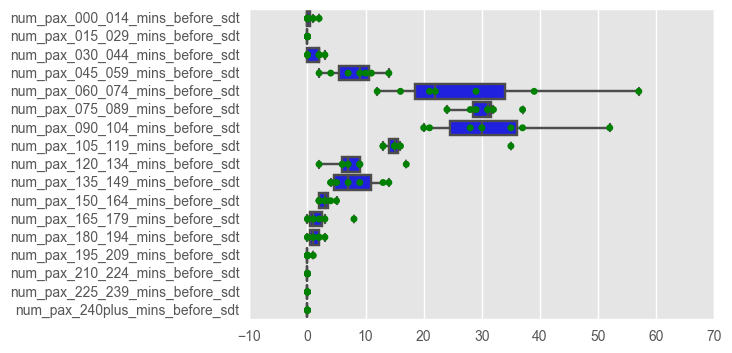

In [209]:
print ("Flight Index:\t\t",index)
print ("Flight no:\t\t",row['cat_i_flightno'])
print ("Prediction Date:\t",row['dt_prediction_date'])
print ("Target Date:\t\t",row['dt_target_date'])
print ("Model Type:\t\t",row['s_model_type'])

test_df=df_train[(df_train['cat_i_flightno']==row['cat_i_flightno']) & (df_train['s_model_type']==row['s_model_type'])]
if not test_df.empty: 
    print ("Historical Data:")
else: 
    print ("No Historical Data")
test_df

ax=sns.boxplot(data=test_df.ix[:,"num_pax_000_014_mins_before_sdt":],orient="h",color="b")
ax=sns.stripplot(data=test_df.ix[:,"num_pax_000_014_mins_before_sdt":],orient="h",color="g")
pred=np.array(test_df.ix[:,"num_pax_000_014_mins_before_sdt":].mean())
pred=np.append([index],pred)
print (pred)

In [197]:
#df_train['cat_sdt_hour']=pd.to_numeric(df_train['cat_sdt_hour'])

x=df_train.iloc[2]
y=df_train.iloc[40]

test_dx=calculate_distance(x,y)
print(test_dx)

2.53850154851


2.53850154851
